In [ ]:
! pip install torchvision matplotlib

In [ ]:
! pip install torchcam

In [ ]:
! pip install git+https://github.com/frgfm/torch-cam.git

## RESNET18 적용

In [8]:
%matplotlib inline
# All imports
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask

from functools import partial
from typing import Any, List, Optional, Tuple, Union

In [9]:
img_path = 'images/ILSVRC2012_val_00000198.JPEG'

In [10]:
model = resnet18(pretrained=True).eval()

In [ ]:
model.modules

In [12]:
cam_extractor = SmoothGradCAMpp(model)
# Get your input
img = read_image(img_path)
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

no value was provided for `target_layer`, thus set to 'layer4'.


In [13]:
# Notice that there is one CAM per target layer (here only 1)
for cam in cams:
  print(cam.shape)

torch.Size([1, 7, 7])


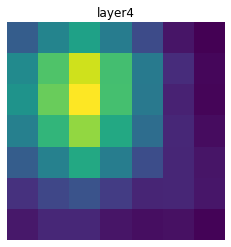

In [14]:
# The raw CAM
for name, cam in zip(cam_extractor.target_names, cams):
  plt.imshow(cam.squeeze().numpy()); plt.axis('off'); plt.title(name); plt.show()

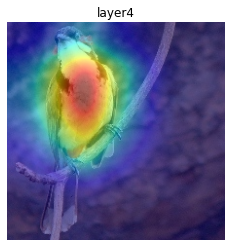

In [15]:
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam, mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

In [16]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()

## 멀티 레이어 합친 레이어 캠

In [17]:
# 모델과 원하는 레이어 입력 => 각 레이어 별 CAM 추출기 생성
cam_extractor = LayerCAM(model, ["layer2", "layer3", "layer4"])

# 인풋 텐서 모델에 넣어서 아웃풋 만들기
out = model(input_tensor.unsqueeze(0))

# 최대 값을 가지는 클래스 인덱스와 모델 출력을 전달하여 CAM 검색
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [28]:
# CAM 사이즈 확인
for cam in cams:
  print(cam.shape)

torch.Size([1, 28, 28])
torch.Size([1, 14, 14])
torch.Size([1, 7, 7])


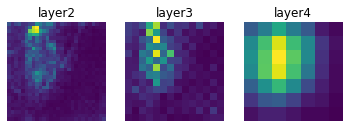

In [29]:
# 실제 추출한 레이어 별 CAM 확인  
# cam_extractor.target_names = ['layer2', 'layer3', 'layer4']
_, axes = plt.subplots(1, len(cam_extractor.target_names))
for idx, name, cam in zip(range(len(cam_extractor.target_names)), cam_extractor.target_names, cams):
  axes[idx].imshow(cam.squeeze().numpy()); axes[idx].axis('off'); axes[idx].set_title(name);
plt.show()

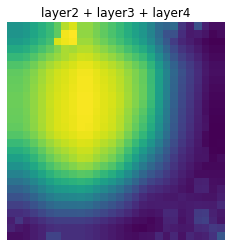

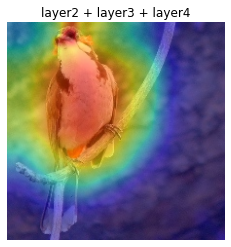

In [31]:
# 캠 합치기
fused_cam = cam_extractor.fuse_cams(cams)

# raw version 사진 출력
plt.imshow(fused_cam.squeeze().numpy()); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()

# overlayed version 사진 출력
result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.5)
plt.imshow(result); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()

In [32]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()

In [121]:
model.layer4

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1